In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import inspect
import textwrap
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from functools import partial
import pickle
from pathlib import Path

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [ ]:
torch.manual_seed(0) #get the same random numbers everytime you run the code

t_span = (0, 10)
n_step = 100
n_data = 1000
coeff_test = 0.3

harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

train, test = create_trainig_test_set(harmonic_osc, t_span, n_step, n_data, coeff_test, "RK45")
print(train["X"][0].shape)
in_features = train["X"][0].shape[0]

torch.Size([103])


In [4]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)

cpu


In [5]:
class Harmonic(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.fc2 = nn.Linear(32, n_step)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = Harmonic(n_step)

In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #updates model parameters based on the gradients computed from the loss, lr = learning rate

In [7]:
epochs = 10000

for epoch in range(epochs):
    T_pred = model(train["X"])
    
    loss = loss_func(T_pred, train["y_tensor"][0:, 0])

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/100)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/10000, Loss: 0.7742
Epoch 200/10000, Loss: 0.7452
Epoch 300/10000, Loss: 0.6547
Epoch 400/10000, Loss: 0.5802
Epoch 500/10000, Loss: 0.5448
Epoch 600/10000, Loss: 0.5324
Epoch 700/10000, Loss: 0.5222
Epoch 800/10000, Loss: 0.5134
Epoch 900/10000, Loss: 0.5026
Epoch 1000/10000, Loss: 0.4922
Epoch 1100/10000, Loss: 0.4800
Epoch 1200/10000, Loss: 0.4666
Epoch 1300/10000, Loss: 0.4519
Epoch 1400/10000, Loss: 0.4327
Epoch 1500/10000, Loss: 0.4141
Epoch 1600/10000, Loss: 0.3956
Epoch 1700/10000, Loss: 0.3727
Epoch 1800/10000, Loss: 0.3514
Epoch 1900/10000, Loss: 0.3297
Epoch 2000/10000, Loss: 0.3127
Epoch 2100/10000, Loss: 0.2975
Epoch 2200/10000, Loss: 0.2853
Epoch 2300/10000, Loss: 0.2766
Epoch 2400/10000, Loss: 0.2647
Epoch 2500/10000, Loss: 0.2556
Epoch 2600/10000, Loss: 0.2561
Epoch 2700/10000, Loss: 0.2378
Epoch 2800/10000, Loss: 0.2279
Epoch 2900/10000, Loss: 0.2234
Epoch 3000/10000, Loss: 0.2086
Epoch 3100/10000, Loss: 0.1973
Epoch 3200/10000, Loss: 0.1915
Epoch 3300/10000,

In [8]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0])
    print(f"Test Loss: {test_loss.item():.4f}")

tensor([[ 0.9314,  0.9825,  1.0308,  ..., -0.8675, -0.8259, -0.7822],
        [ 0.1660,  0.2464,  0.3251,  ...,  0.8179,  0.7866,  0.7516],
        [ 0.4122,  0.4657,  0.5189,  ...,  1.3500,  1.3083,  1.2630],
        ...,
        [ 0.7509,  0.7585,  0.7632,  ...,  0.3583,  0.3811,  0.4005],
        [ 0.8708,  0.8933,  0.9113,  ...,  0.8851,  0.8763,  0.8618],
        [ 0.2537,  0.2622,  0.2694,  ...,  0.3758,  0.3965,  0.4131]])
Test Loss: 0.0346


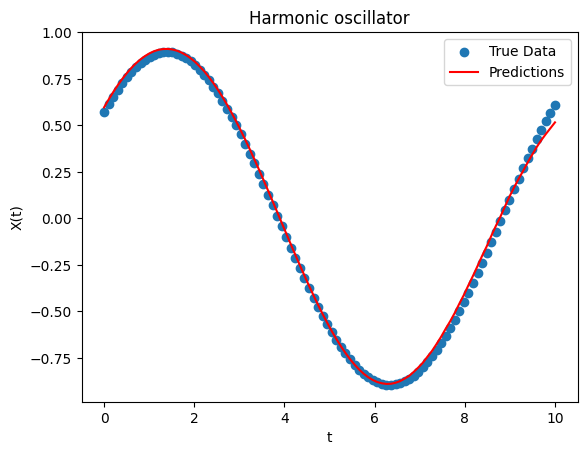

In [9]:
n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.title("Harmonic oscillator")
plt.legend()
plt.show()

# Hyperparameter optimization of the model

In [10]:
train2, validation2, test2 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [11]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, n_layers, n_neurons, activation):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, n_neurons))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
        layers.append(nn.Linear(n_neurons, 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel(4, 2, 32, 'tanh').to(device)

In [12]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    return mse_y

In [13]:
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        t = X[0:, 0:, 3]
        k = X[0:, 0:, 0]
        x_00 = X[0:, 0:, 1]
        x_01 = X[0:, 0:, 2]
    
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
    
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return loss.item()

In [14]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive
        n_neurons = random.randint(neurons_i[0], neurons_i[1])
        activation = random.choice(activations_l)

        params = {
            'n_layers': n_layers,
            'n_neurons': n_neurons,
            'activation': activation
        }

        model = HarmonicModel(4, n_layers, n_neurons, activation).to(device)
        final_loss = train_harmonic(model, lr=0.01, epochs=100, data=data)
        result.append((params, final_loss))
    
    return result


In [15]:
n_trials = 100
results = rng_hparameters_search(n_trials, (1, 10), (1, 100), ['tanh', 'sine', 'gelu', 'relu'], validation2, seed=0)

Hyperparameter search:   1%|          | 1/100 [00:11<19:08, 11.61s/it]

Epoch 100/100, Loss: 0.8232


Hyperparameter search:   2%|▏         | 2/100 [00:12<08:18,  5.09s/it]

Epoch 100/100, Loss: 0.6376


Hyperparameter search:   3%|▎         | 3/100 [00:16<07:55,  4.90s/it]

Epoch 100/100, Loss: 0.1622


Hyperparameter search:   4%|▍         | 4/100 [00:24<09:54,  6.19s/it]

Epoch 100/100, Loss: 0.0287


Hyperparameter search:   5%|▌         | 5/100 [00:27<07:32,  4.76s/it]

Epoch 100/100, Loss: 0.0934


Hyperparameter search:   6%|▌         | 6/100 [00:31<07:24,  4.73s/it]

Epoch 100/100, Loss: 0.2036


Hyperparameter search:   7%|▋         | 7/100 [00:36<07:13,  4.66s/it]

Epoch 100/100, Loss: 0.1689


Hyperparameter search:   8%|▊         | 8/100 [00:37<05:15,  3.43s/it]

Epoch 100/100, Loss: 0.1269


Hyperparameter search:   9%|▉         | 9/100 [00:42<05:58,  3.94s/it]

Epoch 100/100, Loss: 0.0777


Hyperparameter search:  10%|█         | 10/100 [00:46<06:03,  4.04s/it]

Epoch 100/100, Loss: 0.2027


Hyperparameter search:  11%|█         | 11/100 [01:01<10:59,  7.40s/it]

Epoch 100/100, Loss: 0.1580


Hyperparameter search:  12%|█▏        | 12/100 [01:08<10:44,  7.32s/it]

Epoch 100/100, Loss: 0.1774


Hyperparameter search:  13%|█▎        | 13/100 [01:12<09:01,  6.23s/it]

Epoch 100/100, Loss: 0.2427


Hyperparameter search:  14%|█▍        | 14/100 [01:13<06:33,  4.58s/it]

Epoch 100/100, Loss: 0.5550


Hyperparameter search:  15%|█▌        | 15/100 [01:24<09:17,  6.56s/it]

Epoch 100/100, Loss: 0.4180


Hyperparameter search:  16%|█▌        | 16/100 [01:33<10:11,  7.28s/it]

Epoch 100/100, Loss: 0.6413


Hyperparameter search:  17%|█▋        | 17/100 [01:39<09:31,  6.88s/it]

Epoch 100/100, Loss: 0.0687


Hyperparameter search:  18%|█▊        | 18/100 [01:39<06:53,  5.05s/it]

Epoch 100/100, Loss: 0.0882


Hyperparameter search:  19%|█▉        | 19/100 [01:41<05:12,  3.86s/it]

Epoch 100/100, Loss: 0.1237


Hyperparameter search:  20%|██        | 20/100 [01:41<03:46,  2.83s/it]

Epoch 100/100, Loss: 0.2381


Hyperparameter search:  21%|██        | 21/100 [01:49<05:41,  4.32s/it]

Epoch 100/100, Loss: 0.8028


Hyperparameter search:  22%|██▏       | 22/100 [01:54<05:55,  4.56s/it]

Epoch 100/100, Loss: 0.1300


Hyperparameter search:  23%|██▎       | 23/100 [01:56<04:53,  3.81s/it]

Epoch 100/100, Loss: 0.1196


Hyperparameter search:  24%|██▍       | 24/100 [01:59<04:33,  3.60s/it]

Epoch 100/100, Loss: 0.3699


Hyperparameter search:  25%|██▌       | 25/100 [02:00<03:31,  2.83s/it]

Epoch 100/100, Loss: 0.5959


Hyperparameter search:  26%|██▌       | 26/100 [02:07<04:51,  3.93s/it]

Epoch 100/100, Loss: 0.0252


Hyperparameter search:  27%|██▋       | 27/100 [02:08<03:53,  3.19s/it]

Epoch 100/100, Loss: 0.0479


Hyperparameter search:  28%|██▊       | 28/100 [02:09<02:49,  2.36s/it]

Epoch 100/100, Loss: 0.3392


Hyperparameter search:  29%|██▉       | 29/100 [02:09<02:14,  1.89s/it]

Epoch 100/100, Loss: 0.4161


Hyperparameter search:  30%|███       | 30/100 [02:10<01:46,  1.52s/it]

Epoch 100/100, Loss: 0.2095


Hyperparameter search:  31%|███       | 31/100 [02:12<01:58,  1.71s/it]

Epoch 100/100, Loss: 0.1812


Hyperparameter search:  32%|███▏      | 32/100 [02:16<02:39,  2.35s/it]

Epoch 100/100, Loss: 0.0948


Hyperparameter search:  33%|███▎      | 33/100 [02:21<03:25,  3.06s/it]

Epoch 100/100, Loss: 0.1094


Hyperparameter search:  34%|███▍      | 34/100 [02:25<03:37,  3.30s/it]

Epoch 100/100, Loss: 0.2702


Hyperparameter search:  35%|███▌      | 35/100 [02:36<06:14,  5.76s/it]

Epoch 100/100, Loss: 0.0807


Hyperparameter search:  36%|███▌      | 36/100 [02:37<04:36,  4.33s/it]

Epoch 100/100, Loss: 0.4337


Hyperparameter search:  37%|███▋      | 37/100 [02:47<06:17,  5.99s/it]

Epoch 100/100, Loss: 0.6777


Hyperparameter search:  38%|███▊      | 38/100 [02:48<04:48,  4.66s/it]

Epoch 100/100, Loss: 0.1477


Hyperparameter search:  39%|███▉      | 39/100 [02:50<03:39,  3.60s/it]

Epoch 100/100, Loss: 0.0359


Hyperparameter search:  40%|████      | 40/100 [02:51<03:04,  3.08s/it]

Epoch 100/100, Loss: 0.0781


Hyperparameter search:  41%|████      | 41/100 [02:52<02:19,  2.37s/it]

Epoch 100/100, Loss: 0.3623


Hyperparameter search:  42%|████▏     | 42/100 [02:57<02:54,  3.00s/it]

Epoch 100/100, Loss: 0.0289


Hyperparameter search:  43%|████▎     | 43/100 [02:58<02:15,  2.38s/it]

Epoch 100/100, Loss: 0.5956


Hyperparameter search:  44%|████▍     | 44/100 [02:58<01:38,  1.76s/it]

Epoch 100/100, Loss: 0.5130


Hyperparameter search:  45%|████▌     | 45/100 [03:08<03:48,  4.16s/it]

Epoch 100/100, Loss: 0.5321


Hyperparameter search:  46%|████▌     | 46/100 [03:09<02:54,  3.24s/it]

Epoch 100/100, Loss: 0.1384


Hyperparameter search:  47%|████▋     | 47/100 [03:09<02:04,  2.34s/it]

Epoch 100/100, Loss: 0.5489


Hyperparameter search:  48%|████▊     | 48/100 [03:10<01:39,  1.91s/it]

Epoch 100/100, Loss: 0.1432


Hyperparameter search:  49%|████▉     | 49/100 [03:12<01:42,  2.02s/it]

Epoch 100/100, Loss: 0.2093


Hyperparameter search:  50%|█████     | 50/100 [03:13<01:22,  1.65s/it]

Epoch 100/100, Loss: 0.4868


Hyperparameter search:  51%|█████     | 51/100 [03:15<01:20,  1.64s/it]

Epoch 100/100, Loss: 0.1998


Hyperparameter search:  52%|█████▏    | 52/100 [03:15<01:06,  1.38s/it]

Epoch 100/100, Loss: 0.3847


Hyperparameter search:  53%|█████▎    | 53/100 [03:18<01:20,  1.71s/it]

Epoch 100/100, Loss: 0.0983


Hyperparameter search:  54%|█████▍    | 54/100 [03:18<01:00,  1.31s/it]

Epoch 100/100, Loss: 0.2081


Hyperparameter search:  55%|█████▌    | 55/100 [03:19<00:53,  1.20s/it]

Epoch 100/100, Loss: 0.6115


Hyperparameter search:  56%|█████▌    | 56/100 [03:22<01:09,  1.57s/it]

Epoch 100/100, Loss: 0.1737


Hyperparameter search:  57%|█████▋    | 57/100 [03:30<02:34,  3.60s/it]

Epoch 100/100, Loss: 0.2482


Hyperparameter search:  58%|█████▊    | 58/100 [03:33<02:25,  3.46s/it]

Epoch 100/100, Loss: 0.0891


Hyperparameter search:  59%|█████▉    | 59/100 [03:34<01:53,  2.77s/it]

Epoch 100/100, Loss: 0.5131


Hyperparameter search:  60%|██████    | 60/100 [03:36<01:36,  2.40s/it]

Epoch 100/100, Loss: 0.0596


Hyperparameter search:  61%|██████    | 61/100 [03:38<01:27,  2.24s/it]

Epoch 100/100, Loss: 0.1672


Hyperparameter search:  62%|██████▏   | 62/100 [03:38<01:03,  1.68s/it]

Epoch 100/100, Loss: 0.7304


Hyperparameter search:  63%|██████▎   | 63/100 [03:46<02:07,  3.45s/it]

Epoch 100/100, Loss: 0.1350


Hyperparameter search:  64%|██████▍   | 64/100 [03:49<02:06,  3.50s/it]

Epoch 100/100, Loss: 0.6720


Hyperparameter search:  65%|██████▌   | 65/100 [03:52<01:53,  3.25s/it]

Epoch 100/100, Loss: 0.0974


Hyperparameter search:  66%|██████▌   | 66/100 [04:03<03:13,  5.69s/it]

Epoch 100/100, Loss: 0.2059


Hyperparameter search:  67%|██████▋   | 67/100 [04:12<03:37,  6.60s/it]

Epoch 100/100, Loss: 0.3427


Hyperparameter search:  68%|██████▊   | 68/100 [04:16<03:06,  5.81s/it]

Epoch 100/100, Loss: 0.0419


Hyperparameter search:  69%|██████▉   | 69/100 [04:21<02:54,  5.62s/it]

Epoch 100/100, Loss: 0.0664


Hyperparameter search:  70%|███████   | 70/100 [04:28<03:01,  6.07s/it]

Epoch 100/100, Loss: 0.7697


Hyperparameter search:  71%|███████   | 71/100 [04:35<03:00,  6.21s/it]

Epoch 100/100, Loss: 0.0356


Hyperparameter search:  72%|███████▏  | 72/100 [04:38<02:25,  5.21s/it]

Epoch 100/100, Loss: 0.1156


Hyperparameter search:  73%|███████▎  | 73/100 [04:38<01:40,  3.72s/it]

Epoch 100/100, Loss: 1.0908


Hyperparameter search:  74%|███████▍  | 74/100 [04:40<01:20,  3.11s/it]

Epoch 100/100, Loss: 0.0750


Hyperparameter search:  75%|███████▌  | 75/100 [04:44<01:26,  3.44s/it]

Epoch 100/100, Loss: 0.0936


Hyperparameter search:  76%|███████▌  | 76/100 [04:52<02:00,  5.01s/it]

Epoch 100/100, Loss: 0.6967


Hyperparameter search:  77%|███████▋  | 77/100 [04:53<01:25,  3.71s/it]

Epoch 100/100, Loss: 0.4712


Hyperparameter search:  78%|███████▊  | 78/100 [04:53<00:59,  2.69s/it]

Epoch 100/100, Loss: 0.5790


Hyperparameter search:  79%|███████▉  | 79/100 [04:54<00:45,  2.16s/it]

Epoch 100/100, Loss: 0.1719


Hyperparameter search:  80%|████████  | 80/100 [05:01<01:12,  3.65s/it]

Epoch 100/100, Loss: 0.3441


Hyperparameter search:  81%|████████  | 81/100 [05:11<01:45,  5.53s/it]

Epoch 100/100, Loss: 0.3529


Hyperparameter search:  82%|████████▏ | 82/100 [05:13<01:17,  4.28s/it]

Epoch 100/100, Loss: 0.4992


Hyperparameter search:  83%|████████▎ | 83/100 [05:17<01:14,  4.39s/it]

Epoch 100/100, Loss: 0.0867


Hyperparameter search:  84%|████████▍ | 84/100 [05:21<01:07,  4.21s/it]

Epoch 100/100, Loss: 0.2844


Hyperparameter search:  85%|████████▌ | 85/100 [05:22<00:47,  3.18s/it]

Epoch 100/100, Loss: 0.8804


Hyperparameter search:  86%|████████▌ | 86/100 [05:26<00:46,  3.30s/it]

Epoch 100/100, Loss: 0.1342


Hyperparameter search:  87%|████████▋ | 87/100 [05:26<00:31,  2.46s/it]

Epoch 100/100, Loss: 0.8816


Hyperparameter search:  88%|████████▊ | 88/100 [05:37<01:01,  5.09s/it]

Epoch 100/100, Loss: 0.4339


Hyperparameter search:  89%|████████▉ | 89/100 [05:38<00:41,  3.81s/it]

Epoch 100/100, Loss: 0.0565


Hyperparameter search:  90%|█████████ | 90/100 [05:40<00:33,  3.39s/it]

Epoch 100/100, Loss: 0.0207


Hyperparameter search:  91%|█████████ | 91/100 [05:42<00:25,  2.82s/it]

Epoch 100/100, Loss: 0.2231


Hyperparameter search:  92%|█████████▏| 92/100 [05:42<00:16,  2.06s/it]

Epoch 100/100, Loss: 0.5174


Hyperparameter search:  93%|█████████▎| 93/100 [05:44<00:13,  1.93s/it]

Epoch 100/100, Loss: 0.1555


Hyperparameter search:  94%|█████████▍| 94/100 [05:47<00:14,  2.37s/it]

Epoch 100/100, Loss: 0.0240


Hyperparameter search:  95%|█████████▌| 95/100 [05:48<00:09,  1.86s/it]

Epoch 100/100, Loss: 0.2196


Hyperparameter search:  96%|█████████▌| 96/100 [05:48<00:05,  1.43s/it]

Epoch 100/100, Loss: 0.6861


Hyperparameter search:  97%|█████████▋| 97/100 [05:53<00:07,  2.41s/it]

Epoch 100/100, Loss: 0.0251


Hyperparameter search:  98%|█████████▊| 98/100 [05:58<00:06,  3.16s/it]

Epoch 100/100, Loss: 0.0996


Hyperparameter search:  99%|█████████▉| 99/100 [05:59<00:02,  2.49s/it]

Epoch 100/100, Loss: 0.4691


Hyperparameter search: 100%|██████████| 100/100 [06:08<00:00,  3.68s/it]

Epoch 100/100, Loss: 0.5674


In [16]:
# Define your hyperparameter ranges and data
layers_i = (1, 10)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
data = validation2  # your dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    n_neurons = trial.suggest_int("n_neurons", neurons_i[0], neurons_i[1])
    activation = trial.suggest_categorical("activation", activations_l)

    model = HarmonicModel(4, n_layers, n_neurons, activation).to(device)
    final_loss = train_harmonic(model, lr=0.01, epochs=100, data=data)
    return final_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective, layers_i=layers_i, neurons_i=neurons_i,
                                    activations_l=activations_l, data=data)

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=50)


[I 2025-11-24 13:40:03,390] A new study created in memory with name: no-name-be51f0d6-8c6c-44fa-a5de-4b05217e7131
[I 2025-11-24 13:40:03,970] Trial 0 finished with value: 0.1688353717327118 and parameters: {'n_layers': 3, 'n_neurons': 9, 'activation': 'relu'}. Best is trial 0 with value: 0.1688353717327118.


Epoch 100/100, Loss: 0.1688


[I 2025-11-24 13:40:08,228] Trial 1 finished with value: 0.05250982567667961 and parameters: {'n_layers': 8, 'n_neurons': 43, 'activation': 'gelu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.0525


[I 2025-11-24 13:40:14,120] Trial 2 finished with value: 0.11389445513486862 and parameters: {'n_layers': 3, 'n_neurons': 117, 'activation': 'gelu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.1139


[I 2025-11-24 13:40:16,678] Trial 3 finished with value: 0.3294510841369629 and parameters: {'n_layers': 7, 'n_neurons': 26, 'activation': 'gelu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.3295


[I 2025-11-24 13:40:17,414] Trial 4 finished with value: 0.15187335014343262 and parameters: {'n_layers': 3, 'n_neurons': 15, 'activation': 'relu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.1519


[I 2025-11-24 13:40:34,949] Trial 5 finished with value: 0.4757887125015259 and parameters: {'n_layers': 10, 'n_neurons': 109, 'activation': 'relu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.4758


[I 2025-11-24 13:40:42,561] Trial 6 finished with value: 0.18494273722171783 and parameters: {'n_layers': 5, 'n_neurons': 112, 'activation': 'relu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.1849


[I 2025-11-24 13:40:43,884] Trial 7 finished with value: 0.47175732254981995 and parameters: {'n_layers': 1, 'n_neurons': 118, 'activation': 'relu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.4718


[I 2025-11-24 13:40:48,397] Trial 8 finished with value: 0.22802983224391937 and parameters: {'n_layers': 8, 'n_neurons': 42, 'activation': 'gelu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.2280


[I 2025-11-24 13:40:50,198] Trial 9 finished with value: 0.17786096036434174 and parameters: {'n_layers': 10, 'n_neurons': 14, 'activation': 'gelu'}. Best is trial 1 with value: 0.05250982567667961.


Epoch 100/100, Loss: 0.1779


[I 2025-11-24 13:40:57,845] Trial 10 finished with value: 0.018495893105864525 and parameters: {'n_layers': 7, 'n_neurons': 63, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0185


[I 2025-11-24 13:41:07,664] Trial 11 finished with value: 0.1137915626168251 and parameters: {'n_layers': 7, 'n_neurons': 71, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.1138


[I 2025-11-24 13:41:15,916] Trial 12 finished with value: 0.4173111319541931 and parameters: {'n_layers': 8, 'n_neurons': 75, 'activation': 'tanh'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.4173


[I 2025-11-24 13:41:19,560] Trial 13 finished with value: 0.03513345867395401 and parameters: {'n_layers': 5, 'n_neurons': 51, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0351


[I 2025-11-24 13:41:26,760] Trial 14 finished with value: 0.01957538165152073 and parameters: {'n_layers': 5, 'n_neurons': 89, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0196


[I 2025-11-24 13:41:32,268] Trial 15 finished with value: 0.046154674142599106 and parameters: {'n_layers': 4, 'n_neurons': 91, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0462


[I 2025-11-24 13:41:41,273] Trial 16 finished with value: 0.054265253245830536 and parameters: {'n_layers': 6, 'n_neurons': 89, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0543


[I 2025-11-24 13:41:42,311] Trial 17 finished with value: 0.5007855296134949 and parameters: {'n_layers': 1, 'n_neurons': 88, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.5008


[I 2025-11-24 13:41:46,785] Trial 18 finished with value: 0.1740674078464508 and parameters: {'n_layers': 6, 'n_neurons': 61, 'activation': 'tanh'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.1741


[I 2025-11-24 13:41:54,129] Trial 19 finished with value: 0.02929483912885189 and parameters: {'n_layers': 4, 'n_neurons': 99, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0293


[I 2025-11-24 13:42:02,402] Trial 20 finished with value: 0.040678318589925766 and parameters: {'n_layers': 9, 'n_neurons': 60, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0407


[I 2025-11-24 13:42:08,905] Trial 21 finished with value: 0.03579080477356911 and parameters: {'n_layers': 4, 'n_neurons': 100, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0358


[I 2025-11-24 13:42:21,610] Trial 22 finished with value: 0.0863812267780304 and parameters: {'n_layers': 4, 'n_neurons': 127, 'activation': 'sine'}. Best is trial 10 with value: 0.018495893105864525.


Epoch 100/100, Loss: 0.0864


[I 2025-11-24 13:42:30,150] Trial 23 finished with value: 0.01422018464654684 and parameters: {'n_layers': 6, 'n_neurons': 80, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0142


[I 2025-11-24 13:42:39,930] Trial 24 finished with value: 0.030176034197211266 and parameters: {'n_layers': 7, 'n_neurons': 77, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0302


[I 2025-11-24 13:42:46,956] Trial 25 finished with value: 0.3230779767036438 and parameters: {'n_layers': 6, 'n_neurons': 83, 'activation': 'tanh'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.3231


[I 2025-11-24 13:42:52,098] Trial 26 finished with value: 0.02317698486149311 and parameters: {'n_layers': 5, 'n_neurons': 67, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0232


[I 2025-11-24 13:42:57,231] Trial 27 finished with value: 0.030678069218993187 and parameters: {'n_layers': 7, 'n_neurons': 51, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0307


[I 2025-11-24 13:43:16,888] Trial 28 finished with value: 0.20876511931419373 and parameters: {'n_layers': 9, 'n_neurons': 98, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.2088


[I 2025-11-24 13:43:19,734] Trial 29 finished with value: 0.21440134942531586 and parameters: {'n_layers': 2, 'n_neurons': 80, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.2144


[I 2025-11-24 13:43:21,783] Trial 30 finished with value: 0.18326762318611145 and parameters: {'n_layers': 6, 'n_neurons': 33, 'activation': 'tanh'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.1833


[I 2025-11-24 13:43:26,579] Trial 31 finished with value: 0.020424336194992065 and parameters: {'n_layers': 5, 'n_neurons': 66, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0204


[I 2025-11-24 13:43:31,405] Trial 32 finished with value: 0.09032130986452103 and parameters: {'n_layers': 5, 'n_neurons': 59, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0903


[I 2025-11-24 13:43:38,549] Trial 33 finished with value: 0.08616716414690018 and parameters: {'n_layers': 6, 'n_neurons': 69, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0862


[I 2025-11-24 13:43:44,192] Trial 34 finished with value: 0.04317272827029228 and parameters: {'n_layers': 7, 'n_neurons': 51, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0432


[I 2025-11-24 13:43:48,305] Trial 35 finished with value: 0.033531561493873596 and parameters: {'n_layers': 3, 'n_neurons': 83, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0335


[I 2025-11-24 13:43:51,715] Trial 36 finished with value: 0.6668726205825806 and parameters: {'n_layers': 8, 'n_neurons': 34, 'activation': 'gelu'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.6669


[I 2025-11-24 13:43:55,119] Trial 37 finished with value: 0.06564522534608841 and parameters: {'n_layers': 5, 'n_neurons': 64, 'activation': 'relu'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0656


[I 2025-11-24 13:43:59,855] Trial 38 finished with value: 0.05836884677410126 and parameters: {'n_layers': 3, 'n_neurons': 106, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0584


[I 2025-11-24 13:44:06,525] Trial 39 finished with value: 0.2674739360809326 and parameters: {'n_layers': 7, 'n_neurons': 73, 'activation': 'relu'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.2675


[I 2025-11-24 13:44:09,027] Trial 40 finished with value: 0.09098737686872482 and parameters: {'n_layers': 4, 'n_neurons': 45, 'activation': 'gelu'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0910


[I 2025-11-24 13:44:15,616] Trial 41 finished with value: 0.02168313041329384 and parameters: {'n_layers': 5, 'n_neurons': 67, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0217


[I 2025-11-24 13:44:22,071] Trial 42 finished with value: 0.021802609786391258 and parameters: {'n_layers': 5, 'n_neurons': 55, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0218


[I 2025-11-24 13:44:32,816] Trial 43 finished with value: 0.05066969618201256 and parameters: {'n_layers': 6, 'n_neurons': 93, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0507


[I 2025-11-24 13:44:38,095] Trial 44 finished with value: 0.0997605100274086 and parameters: {'n_layers': 5, 'n_neurons': 67, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0998


[I 2025-11-24 13:44:49,480] Trial 45 finished with value: 0.057812340557575226 and parameters: {'n_layers': 8, 'n_neurons': 78, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0578


[I 2025-11-24 13:44:54,881] Trial 46 finished with value: 0.13195182383060455 and parameters: {'n_layers': 6, 'n_neurons': 73, 'activation': 'relu'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.1320


[I 2025-11-24 13:45:04,811] Trial 47 finished with value: 0.3731009066104889 and parameters: {'n_layers': 7, 'n_neurons': 81, 'activation': 'gelu'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.3731


[I 2025-11-24 13:45:10,806] Trial 48 finished with value: 0.02500370889902115 and parameters: {'n_layers': 4, 'n_neurons': 86, 'activation': 'sine'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0250


[I 2025-11-24 13:45:13,849] Trial 49 finished with value: 0.07945392280817032 and parameters: {'n_layers': 5, 'n_neurons': 43, 'activation': 'tanh'}. Best is trial 23 with value: 0.01422018464654684.


Epoch 100/100, Loss: 0.0795


In [17]:
print("Best params:", study.best_params)
print("Best loss:", study.best_value)

Best params: {'n_layers': 6, 'n_neurons': 80, 'activation': 'sine'}
Best loss: 0.01422018464654684


In [18]:
best_params, best_loss = min(results, key=lambda x: x[1])
print("\nBest configuration:")
print(best_params)
print(f"Final loss: {best_loss:.3e}")


Best configuration:
{'n_layers': 5, 'n_neurons': 36, 'activation': 'sine'}
Final loss: 2.074e-02


# Test best hyperparameters

In [19]:
n_layers_opt_rand = best_params["n_layers"]
n_neurons_opt_rand = best_params["n_neurons"]
activation_opt_rand = best_params["activation"]

n_layers_opt_bayes = study.best_params["n_layers"]
n_neurons_opt_bayes = study.best_params["n_neurons"]
activation_opt_bayes = study.best_params["activation"]

model_optimized_rand = HarmonicModel(4, n_layers_opt_rand, n_neurons_opt_rand, activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(4, n_layers_opt_bayes, n_neurons_opt_bayes, activation_opt_bayes).to(device)

In [20]:
# training
loss_last_rand= train_harmonic(model_optimized_rand, 0.01, 1000, train2)
loss_last_bayes = train_harmonic(model_optimized_bayes, 0.01, 1000, train2)

Epoch 1000/1000, Loss: 0.0006
Epoch 1000/1000, Loss: 0.0234


In [24]:
# test dataset random
model_optimized_rand.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred_rand = model_optimized_rand(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_rand = loss_harmonic(y_pred_rand, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Random optimization: {test_loss_rand.item():.4f}")

# test dataset bayes
model_optimized_bayes.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_bayes = loss_harmonic(y_pred_bayes, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Bayesian optimization: {test_loss_bayes.item():.4f}")

Test Loss Random optimization: 0.0066
Test Loss Bayesian optimization: 0.0349


torch.Size([300, 100])
torch.Size([300, 100])


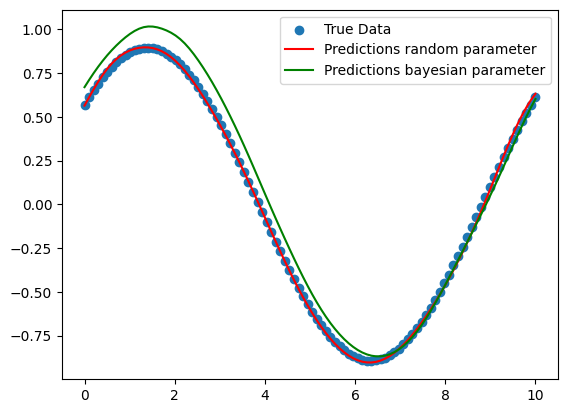

In [22]:
print(y_pred_rand.shape)
print(y_pred_bayes.shape)

y_pred_rand.to("cpu")
y_pred_bayes.to("cpu")
test2["t_tensor"].to("cpu")

n = 30
plt.scatter(test2["t_tensor"][n], test2["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test2["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test2["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

In [23]:
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(
        4,
        best_params['n_layers'],
        best_params['n_neurons'],
        best_params['activation']
    ).to(device)

    # Train model on this fold
    loss = train_harmonic(model, lr=0.01, epochs=100, data=(train_fold, val_fold))
    fold_losses.append(loss)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


TypeError: tuple indices must be integers or slices, not str

# TO DO

- Finish K-fold validation
- Test data on noisy data (physical data)
- Test generalization of model

In [33]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)
# test dataset bayes
model_optimized_bayes.eval()
X = test_generalization["X"]
y_exp_generalization = test_generalization["y_tensor"][0:, 0:, 0].to(device)
y_pred_bayes_generalization = model_optimized_bayes(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
test_loss_bayes_generalization = loss_harmonic(y_pred_bayes_generalization, y_exp_generalization, x_00, x_01, t, k, N_f=100)
print(f"Test Loss Bayesian optimization: {test_loss_bayes_generalization.item():.4f}")

Test Loss Bayesian optimization: 4.5271


torch.Size([300, 100])


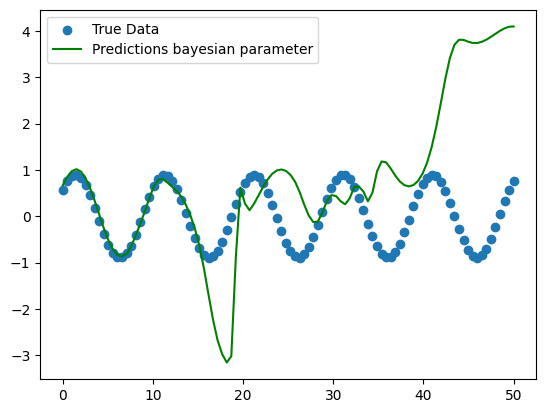

In [34]:
print(y_pred_bayes_generalization.shape)

y_pred_bayes_generalization.to("cpu")
test_generalization["t_tensor"].to("cpu")

n = 30
plt.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test_generalization["t_tensor"][n], y_pred_bayes_generalization.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()